## Climate Adaptation Digital Twin: winter temperature in Germany and Heating Degree Days in Darmstadt 

In this tutorial we will use the [`https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr`](https://earthdatahub.destine.eu/collections/d1-climate-dt-ScenarioMIP-SSP3-7.0-IFS-NEMO/datasets/0001-high-sfc) dataset to take a look at the predicted winter temperature in Germany. We will then compute heating degree days for the city of Darmstadt, for the whole dataset duruation, and show how fast it is to do so in Earth Data Hub.

Access to this dataset is restricted to authorized user only via the the Data Cache Management service. First, make sure you have an account on the [Destination Earth platform](https://platform.destine.eu). Then, with your Destination Earth credentials at hand, run:

In [ ]:
%%capture cap
%run ../cacheb/cacheb-authentication.py

In [ ]:
from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(cap.stdout)

⚠ **NOTE**: the generated password is valid for a limited period of time, and needs to be regenerated and reconfigured periodically by running the cells above.

#### 1. Access and preview the data

In [1]:
import xarray as xr

url = "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr"

ds = xr.open_dataset(
    url, 
    chunks={}, 
    engine="zarr", 
    storage_options={"client_kwargs": {"trust_env": True}}
)
ds

<xarray.Dataset> Size: 188TB
Dimensions:            (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
  * latitude           (latitude) float64 33kB -90.0 -89.96 ... 89.96 90.0
  * longitude          (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23...
Data variables:
    d2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    heightAboveGround  float64 8B ...
    sd                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ssr                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    str                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    t2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate             (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-06-06T16:50 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

⚠ At this point, no data has been downloaded yet, nor loaded in memory.

In [2]:
t2m = ds.t2m
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m

<xarray.DataArray 't2m' (time: 175320, latitude: 4096, longitude: 8193)> Size: 24TB
dask.array<sub, shape=(175320, 4096, 8193), dtype=float32, chunksize=(48, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.91 89.96 90.0
  * longitude  (longitude) float64 66kB -180.0 -180.0 -179.9 ... 180.0 180.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:00:00
Attributes:
    units:    C

#### 2. Narrow down your selection

In [3]:
germany = {'latitude': slice(46, 56), 'longitude': slice(5, 16)}
t2m_germany = t2m.sel(**germany)

t2m_germany_winter = t2m_germany[t2m_germany.time.dt.month.isin([12, 1, 2])]
t2m_germany_winter

<xarray.DataArray 't2m' (time: 43320, latitude: 228, longitude: 251)> Size: 10GB
dask.array<getitem, shape=(43320, 228, 251), dtype=float32, chunksize=(47, 228, 251), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 2kB 46.0 46.04 46.09 ... 55.89 55.93 55.98
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 347kB 2020-01-01 ... 2039-12-31T23:00:00
Attributes:
    units:    C

In [4]:
import costing
costing.estimate_download_size(t2m, t2m_germany_winter)

estimated_needed_chunks: 922
estimated_memory_size: 46.406 GB
estimated_download_size: 4.641 GB


#### 3. Download and compute

This is the phase where we actually dowload and process some data.

In [5]:
%%time

t2m_germany_winter_means = t2m_germany_winter.resample(time='QS-DEC').mean(dim="time")
t2m_germany_winter_means.compute(); # this triggers download and computation

CPU times: user 3min 3s, sys: 1min 19s, total: 4min 22s
Wall time: 1min 34s


In [6]:
t2m_germany_winter_means = t2m_germany_winter_means.dropna("time");

#### 4. Visualization

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import crs
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=2)
ax.gridlines(draw_labels=True, zorder=3, color="white", alpha=0.5)

t2m_germany_winter_means.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=True)

# function to update the plot for each frame (each timestep)
def update(frame):    
    data = t2m_germany_winter_means.isel(time=frame)
    plot = data.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        vmin=-25, 
        vmax=25, 
        add_colorbar=False
    )

    ax.set_title(f"Time: {pd.Timestamp(data['time'].values).strftime('%Y-%m-%d %H:%M:%S')}") 
    return plot

anim = FuncAnimation(fig, update, frames=len(t2m_germany_winter_means['time']), repeat=True) # Create the animation
plt.close() # close the static plot to avoid duplicate display
HTML(anim.to_jshtml()) # display the animation in the notebook



### Heating Degree Days in Darmstadt (HDD)

In [8]:
t2m

<xarray.DataArray 't2m' (time: 175320, latitude: 4096, longitude: 8193)> Size: 24TB
dask.array<sub, shape=(175320, 4096, 8193), dtype=float32, chunksize=(48, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.91 89.96 90.0
  * longitude  (longitude) float64 66kB -180.0 -180.0 -179.9 ... 180.0 180.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:00:00
Attributes:
    units:    C

In [9]:
darmstadt = {"latitude": 49.878708, "longitude": 8.646927}
base_temperature = 15 #[°C]

t2m_darmstadt = t2m.sel(**darmstadt, method="nearest")
t2m_darmstadt

<xarray.DataArray 't2m' (time: 175320)> Size: 701kB
dask.array<getitem, shape=(175320,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 8B 49.87
    longitude  float64 8B 8.657
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:00:00
Attributes:
    units:    C

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
costing.estimate_download_size(t2m, t2m_darmstadt)

estimated_needed_chunks: 3653
estimated_memory_size: 183.862 GB
estimated_download_size: 18.386 GB


In [12]:
%%time
t2m_darmstadt_daily_mean = t2m_darmstadt.resample(time='1D').mean(dim='time')
diff = (base_temperature - t2m_darmstadt_daily_mean)
hdd = diff.where(diff > 0).groupby("time.year").sum()

hdd.compute()

CPU times: user 6min 59s, sys: 4min 54s, total: 11min 53s
Wall time: 3min 38s


<xarray.DataArray 't2m' (year: 20)> Size: 80B
array([1978.1611, 2007.0818, 2197.3755, 2384.5713, 2453.4175, 2241.8225,
       2182.4236, 2155.0173, 2206.7715, 2094.9048, 2129.8838, 2137.711 ,
       2223.3882, 2281.0256, 2203.4006, 1992.7379, 2050.3528, 1808.1298,
       2258.0378, 1972.7424], dtype=float32)
Coordinates:
    latitude   float64 8B 49.87
    longitude  float64 8B 8.657
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0
  * year       (year) int64 160B 2020 2021 2022 2023 ... 2036 2037 2038 2039

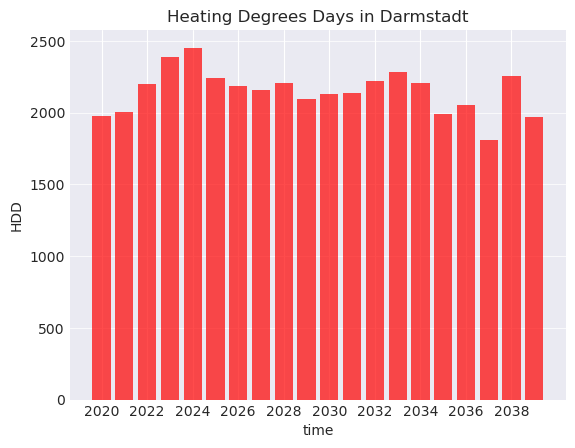

In [13]:
plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots()

plt.bar(hdd.year, hdd.values, color='#ff0000', alpha=0.7)
plt.xlabel('time')
plt.ylabel('HDD')
plt.grid(axis='y', alpha=0.75)
plt.title('Heating Degrees Days in Darmstadt')
plt.xticks(hdd.year[::2]);